# RL 2024 HW1


*   본 자료는 수업시간에 배운 TD(0), n-step TD, TD(𝜆) 등을 구현하도록 구성되어 있습니다.
*   TD(0)는 예시로 구현되어 있습니다. 이를 참조하여 n-step TD, TD(𝜆)를 직접 구현해보도록 합니다.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 본인의 drive 내의 폴더명으로 반드시 변경해주세요
%cd /content/drive/MyDrive/'Colab Notebooks'/RL/HW1_files
!ls
import sys; sys.path.append('..') # add project root to the python path
import numpy as np
import matplotlib.pyplot as plt
from gridworld import *
from tensorized_dp import TensorDP
import pickle

np.random.seed(0)

/content/drive/MyDrive/Colab Notebooks/RL/HW1_files
 episodes_hw1.pkl   gridworld.py   __pycache__	'[RL_HW1] TD.ipynb'   tensorized_dp.py


## `GridWorld` 초기화하기

가로로 `nx` 개, 세로로 `ny` 개의 칸을 가진 `GridworldEnv`를 만듭니다!

In [4]:
nx, ny = 5, 5
env = GridworldEnv([ny, nx])
gamma=1.0
lr=1e-3
dp_agent = TensorDP()
dp_agent.set_env(env)
v_pi = dp_agent.policy_evaluation()

Tensor DP agent initialized
Environment spec:  Num. state = 25 | Num. actions = 4 


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/seeding.py:41: DeprecationWarning: WARN: Function `rng.rand(*size)` is marked as deprecated and will be removed in the future. Please use `Generator.random(size)` instead.
  deprecation(


In [5]:
def get_action(state):

    action = np.random.choice(range(4))

    return action

# Episodes 불러오기

4만개의 Episodes 정보를 불러옵니다



In [6]:
with open('episodes_hw1.pkl','rb') as f:
  episodes=pickle.load(f)


## TD(0)

수업시간에 다룬 TD(0) &ndash; 의 를 이용하여 State Value를 Prediction하는 예시입니다. 1-step TD와 같은 의미입니다. 업데이트 공식은 다음과 같습니다.

$$V(s) \leftarrow V(s) + \alpha (G_t - V(s))$$
$$G_t = R_{t+1} + \gamma V(s_{t+1}) $$

수식에서도 확인하실수 있듯이, 1-step TD는 $(s_t, a_t, r_t, s_{t+1})$ 만으로도 업데이트를 수행할 수 있습니다.

그렇기 때문에 TD 방식은 MC 방식과 달리 Episode를 진행하는 도중에 Value를 추산할 수 있습니다.

(주의) 성능 비교를 위해, 오차값을 td_error 라는 이름의 list에 저장합니다. 숙제에 포함되는 n_td_error, lambda_td_error 를 설정할 때,
 참조하시길 바랍니다.


In [7]:
td_error=[]
v_td=np.zeros(shape=nx*ny)
q_td = np.zeros(shape=(nx*ny,4))
log_every = 10000

log_iters=[]
values=[]
i=0

for episode in episodes:

  states,actions,rewards,next_states,dones=episode
  iter=zip(states,actions,rewards,next_states,dones)

  for state,action,reward,next_state,done in iter:

      # 1-step TD target
      # V 함수 추정
    td_target = reward +gamma * v_td[next_state] * (1 - done)
    v_td[state] += lr * (td_target - v_td[state])
    # Q 함수 추정

    td_target=reward+gamma*q_td[next_state,np.argmax(q_td[next_state])]* (1 - done)
    q_td[state,action]+=lr*(td_target-q_td[state,action])

  td_error.append(np.linalg.norm(v_td-v_pi))

  if i%log_every==0:
    values.append(v_td.copy())
    log_iters.append(i)

  i+=1

info=dict()
info['values']=values
info['iters']=log_iters

## TD(0) Prediction 과정 확인하기

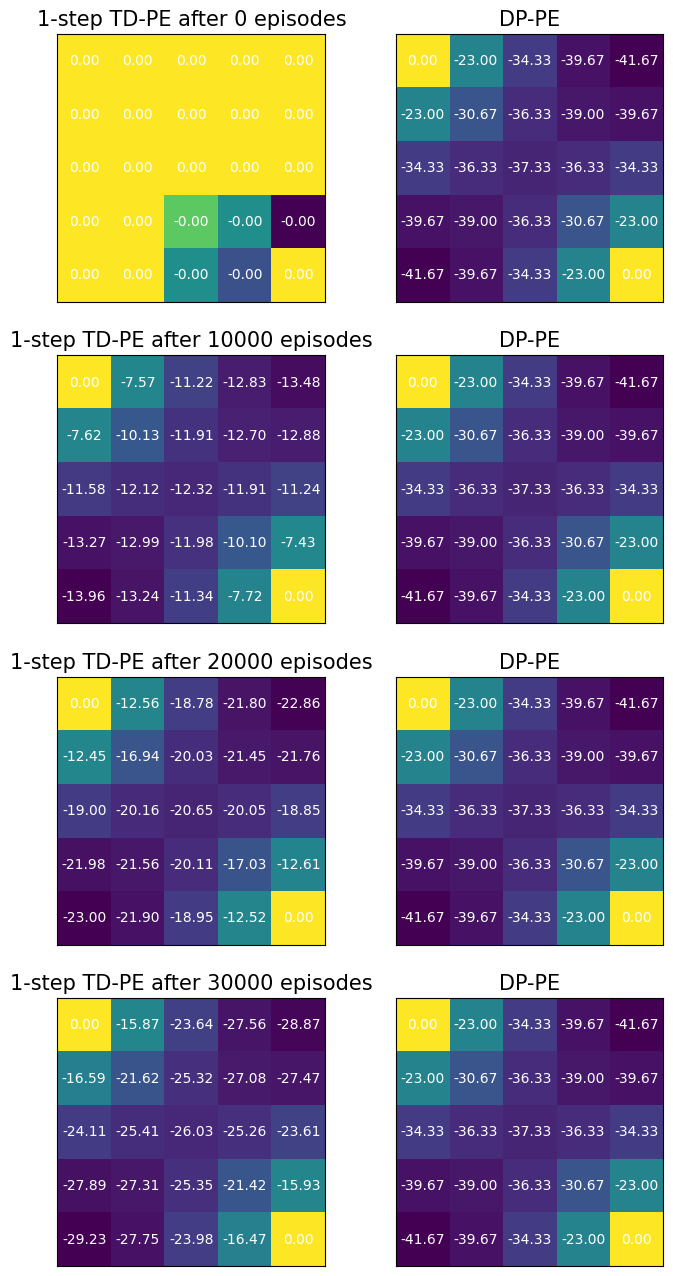

In [8]:
log_iters = info['iters']
td_values = info['values']

n_rows = len(log_iters)
figsize_multiplier = 4


fig, ax = plt.subplots(n_rows, 2, figsize=(2*figsize_multiplier,
                                           n_rows*figsize_multiplier))

for viz_i, i in enumerate(log_iters):
    visualize_value_function(ax[viz_i, 0], td_values[viz_i], nx, ny,
                            plot_cbar=False)
    _ = ax[viz_i, 0].set_title("1-step TD-PE after {} episodes".format(i), size=15)

    visualize_value_function(ax[viz_i, 1], v_pi, nx, ny,
                             plot_cbar=False)
    _ = ax[viz_i, 1].set_title("DP-PE", size=15)

# n-step TD

여기서 부터 직접 작성할 것

아래의 수식을 따름

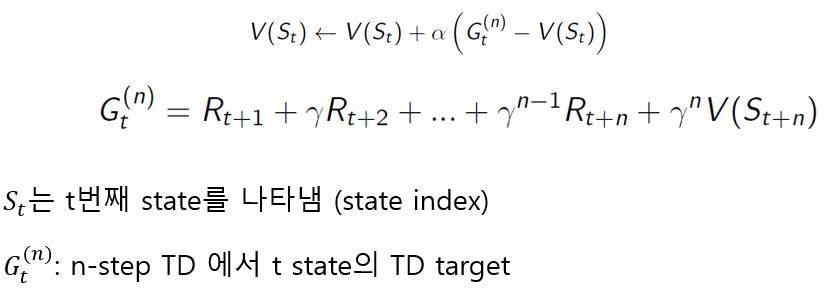

n_step = 5
* 나머지 transit이 5보다 적게 남은 경우는 남아있는 경우는 episode가 끝날때 까지 값만 사용함

* v_n_td : state value 값

구현되어 있는 부분은 수정하지 말고, "Implement Here" 부분 내에서만 코드를 작성하세요


In [41]:
n_td_error=[]
v_n_td=np.zeros(shape=nx*ny)
q_td = np.zeros(shape=(nx*ny,4))
log_every = 10000
n_step=5

log_iters=[]
values=[]
j=0

for episode in episodes:

    states, actions, rewards, next_states, dones = episode
    iter = zip(states, actions, rewards, next_states, dones)

    buffer = [] # n-step 저장소
    for state, action, reward, next_state, done in iter:
        buffer.append((state, action, reward))
        if len(buffer) >= n_step:
            G = sum([reward for _, _, reward in buffer])
            if not done:
                G += (gamma ** n_step) * v_n_td[next_state]

            state_to_update = buffer.pop(0)[0] #오래된 state pop
            v_n_td[state_to_update] += lr * (G - v_n_td[state_to_update])

    while buffer: #buffer 5개 미만
        G = sum([reward for _, _, reward in buffer])
        if len(buffer) == 1:
            if not done:
                G += gamma * v_n_td[next_state]
        else:
            if not done:
                G += (gamma ** len(buffer)) * v_n_td[next_state]

        state_to_update = buffer.pop(0)[0]
        v_n_td[state_to_update] += lr * (G - v_n_td[state_to_update])


    n_td_error.append(np.linalg.norm(v_n_td-v_pi))

    if j%log_every==0:
      values.append(v_n_td.copy())
      log_iters.append(j)

    j+=1

info=dict()
info['values']=values
info['iters']=log_iters

## n-step TD Prediction 과정 확인하기

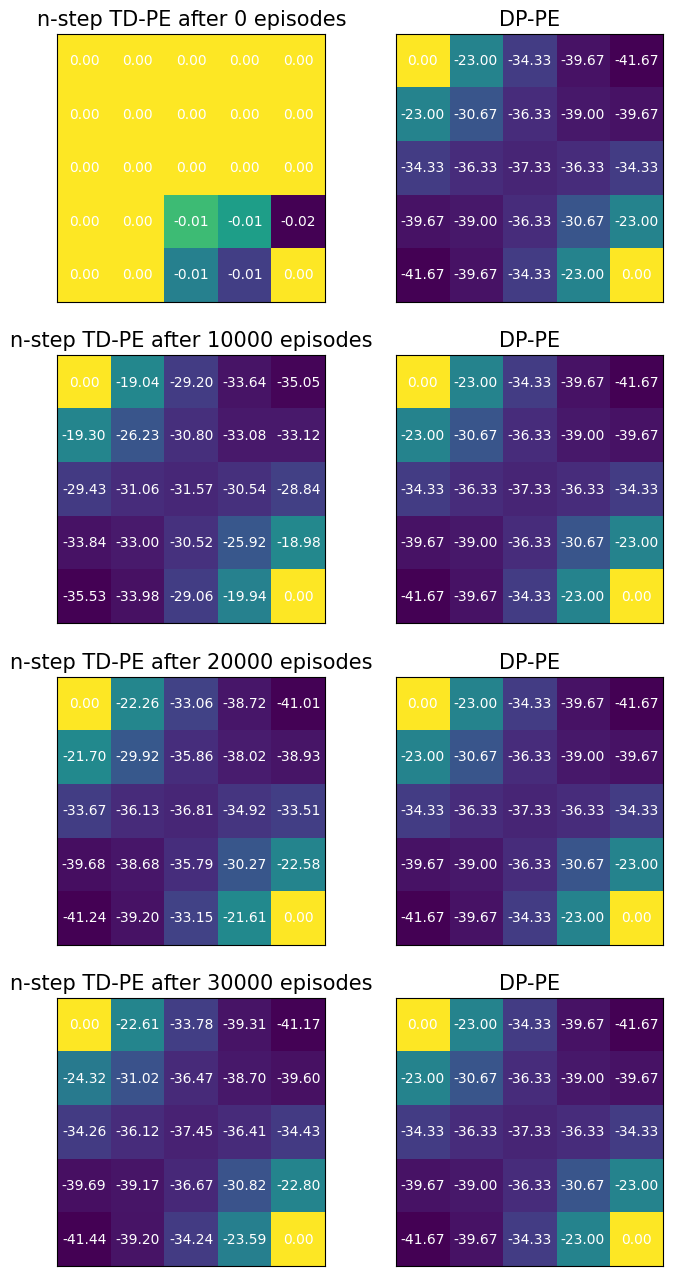

In [42]:
log_iters = info['iters']
n_td_values = info['values']

n_rows = len(log_iters)
figsize_multiplier = 4

fig, ax = plt.subplots(n_rows, 2, figsize=(2*figsize_multiplier,
                                           n_rows*figsize_multiplier))

for viz_i, i in enumerate(log_iters):
    visualize_value_function(ax[viz_i, 0], n_td_values[viz_i], nx, ny,
                            plot_cbar=False)
    _ = ax[viz_i, 0].set_title("n-step TD-PE after {} episodes".format(i), size=15)

    visualize_value_function(ax[viz_i, 1], v_pi, nx, ny,
                             plot_cbar=False)
    _ = ax[viz_i, 1].set_title("DP-PE", size=15)

# TD(λ) 구현하기

- 현재 state의 TD-error와 dligibility trace를 이용하여 backward TD(λ) 를 직접 구현하는 문제입니다. 아래의 알고리즘을 따라서 작성하시면 됩니다.

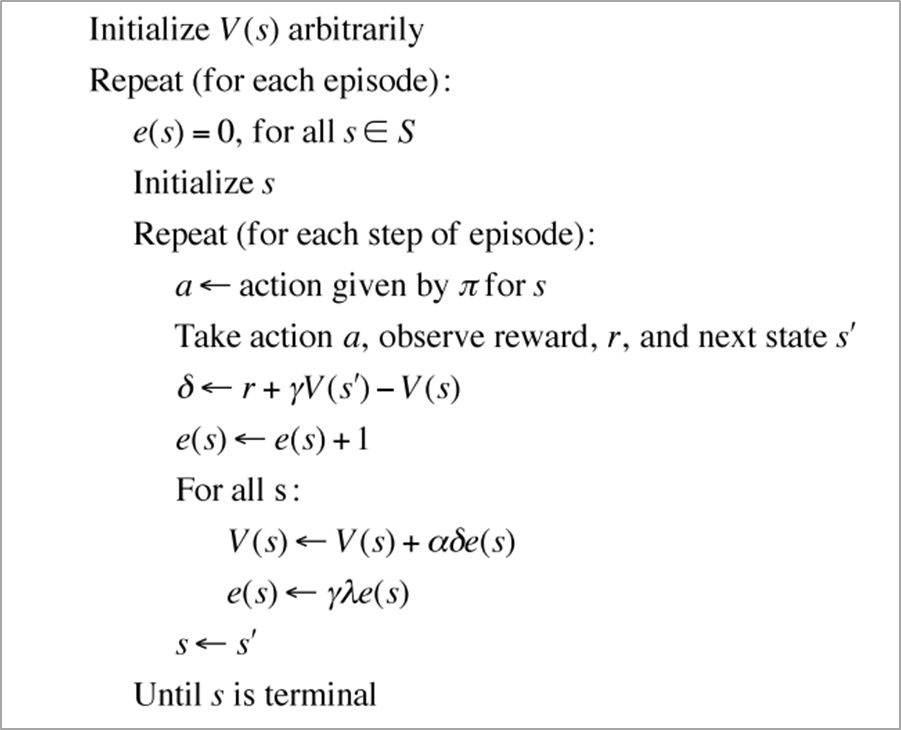

- 조건


*   λ = 0.5
* v_lambda_td : state value 값

구현되어 있는 부분은 수정하지 말고, "Implement Here" 부분 내에서만 코드를 작성하세요




In [43]:
lmbda=0.5

lambda_td_error=[]
v_lambda_td=np.zeros(shape=nx*ny)
log_every = 10000

log_iters=[]
values=[]
i=0

for episode in episodes:
    e = np.zeros(shape=nx*ny)

    states, actions, rewards, next_states, dones = episode
    iter = zip(states, actions, rewards, next_states, dones)

    for state, action, reward, next_state, done in iter:
        delta = reward + (gamma * v_lambda_td[next_state]) - v_lambda_td[state]
        e[state] += 1

        for state in range(nx * ny):
          v_lambda_td[state] += lr * delta * e[state]
          e[state] = gamma * lmbda * e[state]


    lambda_td_error.append(np.linalg.norm(v_lambda_td-v_pi))

    if i % log_every == 0:
        values.append(v_lambda_td.copy())
        log_iters.append(i)

    i += 1

info=dict()
info['values']=values
info['iters']=log_iters

# TD(λ) Prediction 과정 확인하기

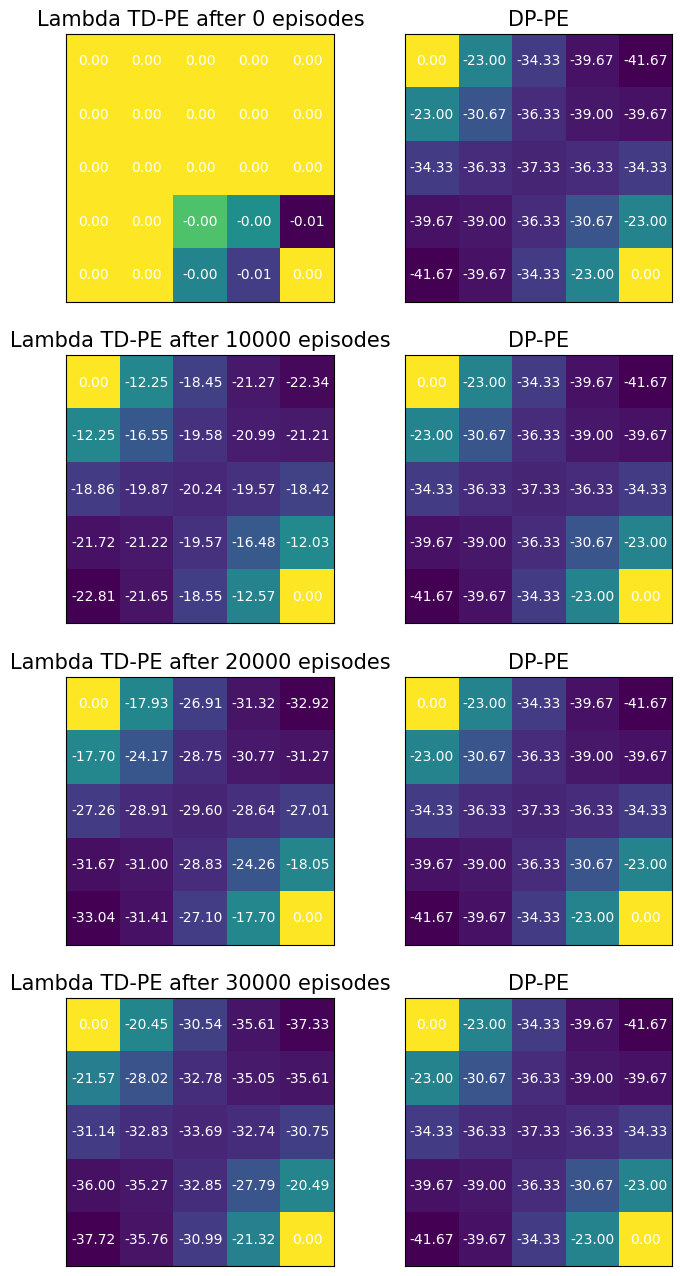

In [44]:
log_iters = info['iters']
lambda_td_values = info['values']

n_rows = len(log_iters)
figsize_multiplier = 4

fig, ax = plt.subplots(n_rows, 2, figsize=(2*figsize_multiplier,
                                           n_rows*figsize_multiplier))

for viz_i, i in enumerate(log_iters):
    visualize_value_function(ax[viz_i, 0], lambda_td_values[viz_i], nx, ny,
                            plot_cbar=False)
    _ = ax[viz_i, 0].set_title("Lambda TD-PE after {} episodes".format(i), size=15)

    visualize_value_function(ax[viz_i, 1], v_pi, nx, ny,
                             plot_cbar=False)
    _ = ax[viz_i, 1].set_title("DP-PE", size=15)

# 수렴 비교


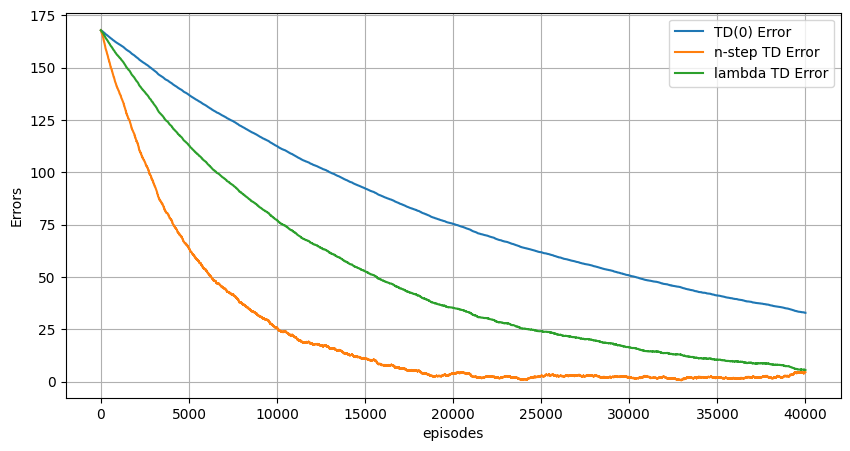

In [45]:
iters=np.arange(40000)
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.grid()
ax.plot(iters, td_error, label='TD(0) Error')
ax.plot(iters, n_td_error, label='n-step TD Error')
ax.plot(iters, lambda_td_error, label='lambda TD Error')

ax.legend()
_ = ax.set_xlabel('episodes')
_ = ax.set_ylabel('Errors')